<a href="https://colab.research.google.com/github/glorivaas/Risk_Measures/blob/main/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Elliptical distributions intro
## Author: Gloria Rivas

### Exercise 1
Construct a QQ plot of the SPX500 index data obtained in the previous notebook

Use a statistical test to check for normality of the returns (e.g., Jarque-Bera test).

[*********************100%***********************]  20 of 20 completed


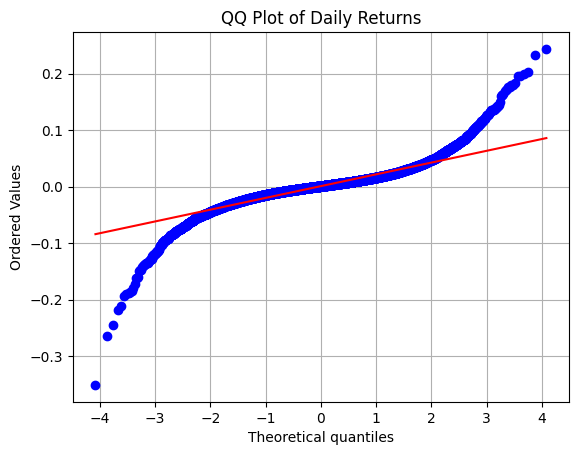

Daily - Jarque-Bera Test Statistic: 216494.58
Daily - p-value: 0.00000
Reject normality




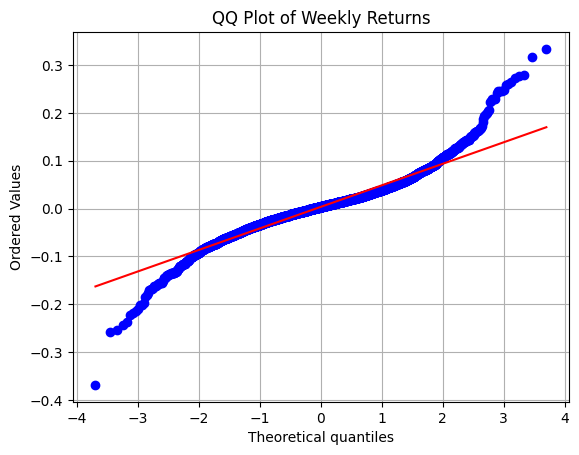

Weekly - Jarque-Bera Test Statistic: 7347.32
Weekly - p-value: 0.00000
Reject normality




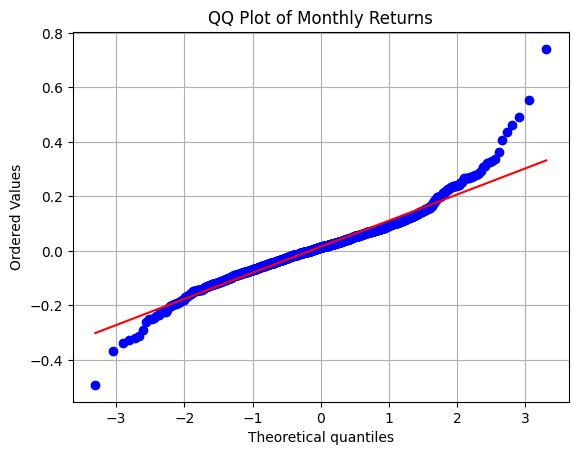

Monthly - Jarque-Bera Test Statistic: 1381.07
Monthly - p-value: 0.00000
Reject normality




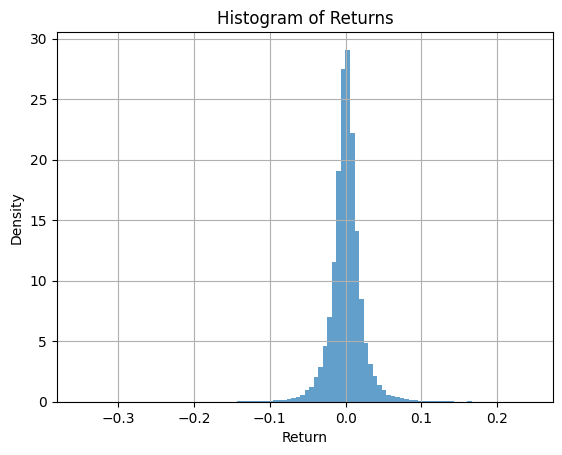

In [21]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "NVDA", "NFLX", "JPM", "V",
           "PG", "DIS", "INTC", "PFE", "KO", "PEP", "XOM", "CSCO", "C", "IBM"]

data = yf.download(tickers, start="2018-01-01", end="2024-02-28")["Close"]
returns = data.pct_change().dropna()

from scipy import stats
import matplotlib.pyplot as plt

def normality_check(returns, label="Daily"):
    returns_flat = returns.values.flatten()

    stats.probplot(returns_flat, dist="norm", plot=plt)
    plt.title(f"QQ Plot of {label} Returns")
    plt.grid(True)
    plt.show()

    jb_stat, jb_pvalue = stats.jarque_bera(returns_flat)
    print(f"{label} - Jarque-Bera Test Statistic: {jb_stat:.2f}")
    print(f"{label} - p-value: {jb_pvalue:.5f}")

    if jb_pvalue < 0.05:
        print("Reject normality")
    else:
        print("Fail to reject normality")
    print("\n")

normality_check(daily_returns, label="Daily")
normality_check(weekly_returns, label="Weekly")
normality_check(monthly_returns, label="Monthly")

plt.hist(returns.values.flatten(), bins=100, density=True, alpha=0.7)
plt.title("Histogram of Returns")
plt.xlabel("Return")
plt.ylabel("Density")
plt.grid(True)
plt.show()

We can observe some heavy tails (which means we have some extreme values) and a "S" shape that suggest that the returns are not notmally distributed, but let's check it as requested.
Additionally, I represented the histogram of the data to check that, indeed, it does not look normally distributed (very high spike and fat tails).

And the Jaque-Bera test confirms our theory: a P-value of aprox 0 means that we reject the null hypothesis that the SPX500 returns are normally distributed, for all three cases. Futhermore, 216494.58 is a very large value, indicating extreme deviation from normality. For weekly returns this value is quite lower (7347.32) and even more fro monthly ones (1381.07). This is consistent with the expectation that aggregating returns (over longer time periods) makes them appear closer to normal, though still not perfectly.

### Exercise 2
Let $\hat{\mu}, \hat{\Sigma}$ be the standard mean and covariance estimators of the returns of the family of stocks, obtained in the previous notebook.

Define
$$
D_i^2 = (X_i-\hat{\mu})^T\hat{\Sigma}^{-1}(X_i-\hat{\mu})
$$
where $i=1,\ldots, n_{obs}$ and $X_i$ is the vector of observed returns at day $i$.

Under the normality assumption of the returns, it can be shown that $D_i^2$ is approximately $\chi_d^2$ distributed.
Construct a QQ plot of the observed $D_i$ against this distribution.


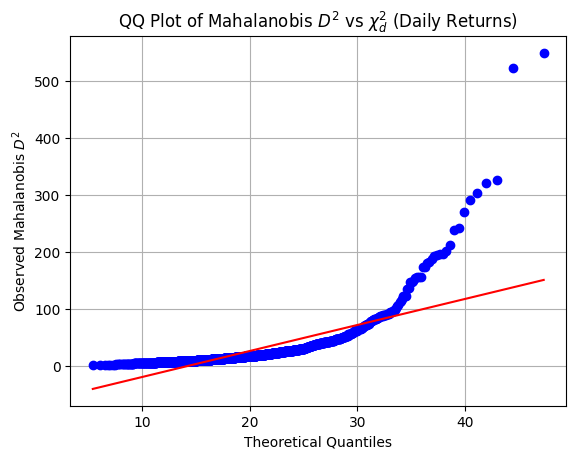

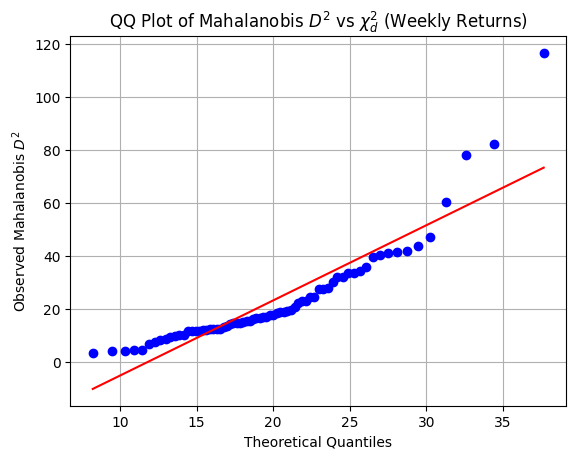

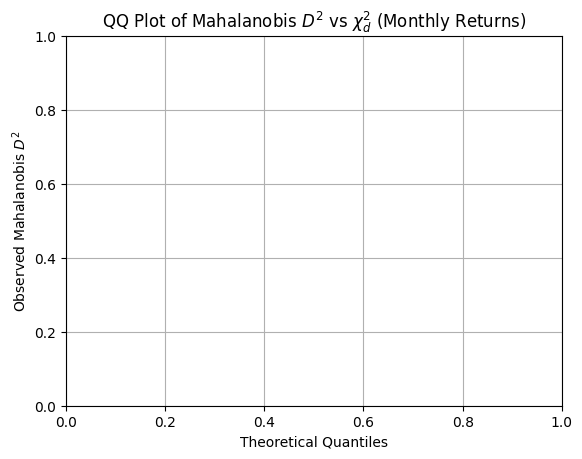

In [22]:
from scipy.linalg import inv
import numpy as np

def mahalanobis_qq(returns, window=250, label="Daily"):
    X = returns.values
    d = X.shape[1]
    D_squared = []

    for t in range(window, len(X)):
        window_data = X[t - window:t]
        mu = np.mean(window_data, axis=0)
        Sigma = np.cov(window_data, rowvar=False)
        inv_Sigma = inv(Sigma)

        x = X[t]
        diff = x - mu
        D_sq = diff @ inv_Sigma @ diff
        D_squared.append(D_sq)

    D_squared = np.array(D_squared)

    stats.probplot(D_squared, dist="chi2", sparams=(d,), plot=plt)
    plt.title(f"QQ Plot of Mahalanobis $D^2$ vs $\\chi^2_d$ ({label} Returns)")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Observed Mahalanobis $D^2$")
    plt.grid()
    plt.show()

mahalanobis_qq(daily_returns, label="Daily")
mahalanobis_qq(weekly_returns, label="Weekly")
mahalanobis_qq(monthly_returns,win label="Monthly")



The QQ plot shows significant deviation from the reference line, particularly in the right tail. This indicates that the multivariate returns do not follow a multivariate normal distribution, as the extreme values are more frequent than expected. This result is consistent with the results from exercise 1, where the Jarque-Bera test rejected the null hypothesis of normality for the marginal distributions of returns.

### Exercise 3

We want to test if $X\sim E_d(\mu,\Sigma, \psi)$ for some parameters, using the observations of a sample of SP500 stocks.
1. Argue that one can use the estimates $\hat{\mu}$, $\hat{\Sigma}$ from the previous exercise for estimating $\mu$, $\Sigma$.
2. Using the estimate $\hat{\mu}$, $\hat{\Sigma}$, calculate $Y_i = \hat{\Sigma}^{-1/2}(X-\hat{\mu})$.
3. Calculate beta statistics of $Y$, $T(Y) = \frac{\sum_{i=1}^k Y_i^2}{\sum_{i=1}^d Y_i^2}$ for various $k$.
4. Generate a QQ plot of these statistics against the corresponding beta distributions.